# Overview 

This notebook shows how to define a GP with prior mean.
In particular, the prior mean depends on trainable parameters, that are inferred during hyperparameter optimization.

In [1]:
import matplotlib.pyplot as plt

import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import Mean

In [2]:
# Define syntetic data
X = torch.tensor([0.03, 0.06, 0.6, 0.7, 0.75, 0.98]).reshape(-1, 1).to(dtype=torch.float64)
y = 0*torch.rand(len(X),1) + torch.sin(9*X)

In [3]:
# Define prior mean module with trainable phase
class CosMean(Mean):

    def __init__(self):
        super(CosMean, self).__init__()
        self.register_parameter(name="phase", parameter=torch.nn.Parameter(torch.zeros([])))

    def forward(self, input):
        return torch.cos( 9*input + self.phase ).flatten()

In [4]:
# Define GP, which includes the phase of the prior mean to the data
gp = SingleTaskGP(X, y, mean_module=CosMean())

# Print initial hyperparameters
for p in gp.named_parameters():
    print(p)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0067], dtype=torch.float64, requires_grad=True))
('mean_module.phase', Parameter containing:
tensor(0., dtype=torch.float64, requires_grad=True))
('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.2048]], dtype=torch.float64, requires_grad=True))


In [5]:
# Train GP, which includes fitting the phase of the prior mean to the data
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

# New hyperparameters; note that the phase has been optimized
for p in gp.named_parameters():
    print(p)


Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x162ea98a0>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x162e75d30>
attempt 1
method: L-BFGS-B
options None
x0 None
('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0057], dtype=torch.float64, requires_grad=True))
('mean_module.phase', Parameter containing:
tensor(-1.6153, dtype=torch.float64, requires_grad=True))
('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.1652]], dtype=torch.float64, requires_grad=True))


In [9]:
def plot():
    plt.figure(figsize=(4,2.5))
    plt.xlabel('Input $x_1$')
    plt.ylabel('Objective function $f$')
    #plot mean and confidence region
    plt.plot(x, m, color='C0', lw=1)
    plt.fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0, color='C0')

    plt.plot(X, y, 'o', color='C0')
    plt.xlim(0,1)
    plt.ylim(-1.5, 2.5)


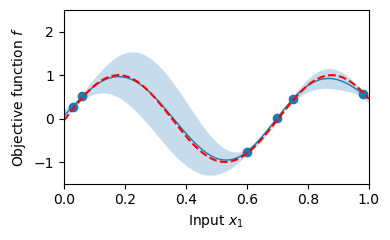

In [10]:
x = torch.linspace(0, 1, 200, dtype=torch.float64)
with torch.no_grad():
    p = gp.posterior(x)

    #get the mean
    m = p.mean

    #get the 2 sigma confidence region around the mean
    l,u = p.mvn.confidence_region()

plot()
plt.plot( x, gp.mean_module.forward(x).detach(), 'r--' )
plt.tight_layout()